### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Import functions for computing summary statistics
import resampled_stats as rs

Set font sizes for plots

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---

# Open dataset

In [4]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray().squeeze()

### Compute daily median snow depth

I also do some data cleanup here. To remove "spikes" that show up in the original data, take the difference between each adjacent 5-minute timestep, then take the absolute value of this difference. Ignore any snowdepth values where that difference is > 1 cm in 5 minutes. 

Then resample to the daily median of the remaining depth values. There are still a few erroneous large daily snowdepth values, so finally filter out depths > 570 cm since those are larger than any other values in the timeseries. 

Replace all NaN values with linearly interpolated values. Finally add our cleaned up daily median snow depths to the original dataset.

In [5]:
# compute the difference between each timestep, take the absolute value of this difference
deltas = np.abs(cues_ds['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].diff('datetime',1))
# ignore any snowdepth values where the change is > 1 cm in 5 minutes
depths_adj = cues_ds['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].where(deltas<1)
# resample to daily and compute median
daily_median_snow_depth = depths_adj.resample(datetime="1D").median()
# rename this DataArray
daily_median_snow_depth = daily_median_snow_depth.rename('daily_median_snow_depth')
# fill nan values by day (I have to go back to a pandas Dataframe here)
daily_median_snow_depth = daily_median_snow_depth.to_dataframe().loc[cues_ds.to_dataframe().index].fillna(method='bfill')
# remove depths that are larger than the maximum I've identified (570 cm)
max_daily_median_snowdepth = 570
daily_median_snow_depth = daily_median_snow_depth.where(daily_median_snow_depth<max_daily_median_snowdepth)
# convert back into an xarray (Dataset)
daily_median_snow_depth = daily_median_snow_depth.to_xarray()
# interpolate to fill missing values
daily_median_snow_depth = daily_median_snow_depth.interpolate_na('datetime', method='linear')
# finally pull out the values we want, put back into the original dataset as a new variable
cues_ds['daily_median_snow_depth'] = (['datetime'], daily_median_snow_depth.daily_median_snow_depth)

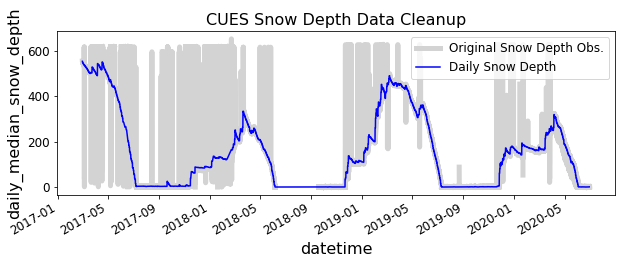

In [6]:
plt.figure(figsize=(10,3))
cues_ds['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].plot(linewidth=5, color='lightgrey', label='Original Snow Depth Obs.')
cues_ds.daily_median_snow_depth.plot(color='b',label='Daily Snow Depth')
plt.title('CUES Snow Depth Data Cleanup')
plt.legend();

### Compute diff

(GOES Tb - CUES Tss) and add it to the dataset

In [7]:
cues_ds['goes_cues_diff'] = cues_ds.goes_tb_c - cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

### Filter entire dataset to only snow-on conditions

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where cloud_flag=0.

In [8]:
snow_depth_treshold = 5 # cm

filter_conditions = ((cues_ds.cloud_flag == 0) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

In [9]:
cues_snow = cues_ds.where(filter_conditions)

### Define plotting functions

In [10]:
def resampled_plot(resampled_df, ymin=-20, ymax=20, xmin=0, xmax=400, nbins=100):

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4), 
                           tight_layout=True, sharey=True,
                           gridspec_kw={'width_ratios': [1, 1, 1, 5]})
    
    ### Histograms ###
    # mean histogram
    resampled_df.means.plot.hist(ax=ax[0],
                                  bins=nbins, 
                                  orientation='horizontal',
                                  color = '#000000',
                                  ec='none',
                                  lw=1)
    ax[0].axhline(0,color='r',linestyle=':')
    ax[0].set_title('Mean Difference')
    ax[0].set_xlim((xmin,xmax))
    
    # median histogram
    resampled_df.medians.plot.hist(ax=ax[1],
                                    bins=nbins, 
                                    orientation='horizontal',
                                    color = '#000000',
                                    ec='none',
                                    lw=1)
    ax[1].axhline(0,color='r',linestyle=':')
    ax[1].set_title('Median Difference')
    ax[1].set_xlim((xmin,xmax))
    
    # mode histogram
    resampled_df.modes.plot.hist(ax=ax[2],
                                       bins=nbins, 
                                       orientation='horizontal',
                                       color = '#000000',
                                       ec='none',
                                       lw=1)
    ax[2].axhline(0,color='r',linestyle=':')
    ax[2].set_title('Mode Difference')
    ax[2].set_xlim((xmin,xmax))
    
    
    ### Timeseries "Boxplots" ###
    # mean marker
    resampled_df.means.plot(linestyle='none',marker='o',color='k', label='Mean', ax=ax[3])
    # median marker
    resampled_df.medians.plot(linestyle='none',marker='_',color='k', label='Median', ax=ax[3])
    # mode marker
    resampled_df.modes.plot(linestyle='none',marker='o',markerfacecolor='w',markeredgecolor='k', label='Mode', ax=ax[3])
    
    # lower and upper quartile error bars
    ax[3].errorbar(x=resampled_df.index, 
                y=resampled_df.means,
                yerr=np.array([np.abs(resampled_df.qLower-resampled_df.means), 
                               np.abs(resampled_df.qUpper-resampled_df.means)]),
                fmt='none',
                linewidth=1,
                color='k',
                alpha=0.4,
                capsize=None,
                label='IQR')
    
    ax[3].axhline(0,linestyle='-',color='lightgrey',linewidth=1)
    plt.legend()
    
    # Format shared y-axis
    ax[0].set_ylim(ymin,ymax);
    ax[0].set_ylabel('GOES $T_{B}$ - CUES $T_{SS}$ [$\Delta\degree C$]')
    
    return fig, ax

In [11]:
def resampled_plot2(original_df, resampled_df, ymin=-20, ymax=20, xmin=0, xmax=400, nbins=100):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4), 
                           tight_layout=True, sharey=True,
                           gridspec_kw={'width_ratios': [1, 4]})
    
    ### Original Dataframe, Histogram ###
    original_df.plot.hist(ax=ax[0],
                          bins=nbins, 
                          orientation='horizontal',
                          color = '#000000',
                          ec='none',
                          lw=1)
    ax[0].axhline(0,color='r',linestyle=':')
    ax[0].set_title('Difference')
    ax[0].set_xlim((xmin,xmax))
    
    ### Resampled Dataframe, Timeseries "Boxplots" ###
    # mean marker
    resampled_df.means.plot(linestyle='none',marker='o',color='k', label='Mean', ax=ax[1])
    # median marker
    resampled_df.medians.plot(linestyle='none',marker='_',color='k', label='Median', ax=ax[1])
    # mode marker
    resampled_df.modes.plot(linestyle='none',marker='o',markerfacecolor='w',markeredgecolor='k', label='Mode', ax=ax[1])
    
    # lower and upper quartile error bars
    ax[1].errorbar(x=resampled_df.index, 
                y=resampled_df.means,
                yerr=np.array([np.abs(resampled_df.qLower-resampled_df.means), 
                               np.abs(resampled_df.qUpper-resampled_df.means)]),
                fmt='none',
                linewidth=1,
                color='k',
                alpha=0.4,
                capsize=None,
                label='IQR')
    
    ax[1].axhline(0,linestyle='-',color='lightgrey',linewidth=1)
    plt.legend()
    
    # Format shared y-axis
    ax[0].set_ylim(ymin,ymax);
    ax[0].set_ylabel('GOES $T_{B}$ - CUES $T_{SS}$ [$\Delta\degree C$]')
    
    return fig, ax

---

# Boxplots and Histograms

Resample, compute summary stats

### 3H resample

(<Figure size 1008x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9631f36908>,
       dtype=object))

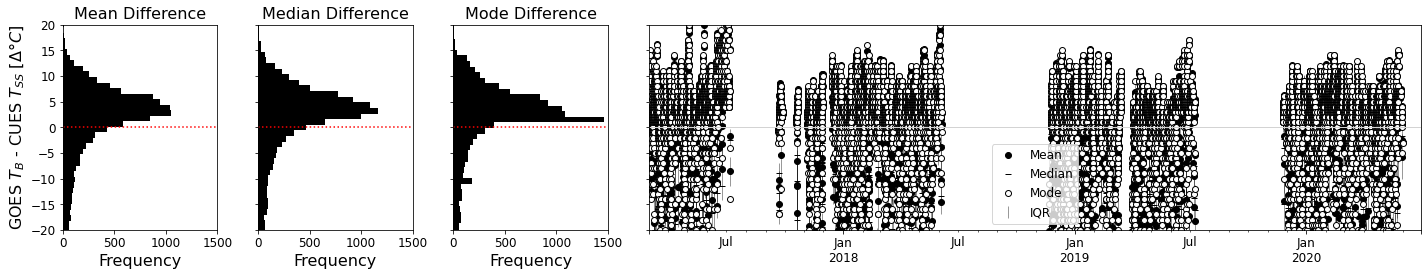

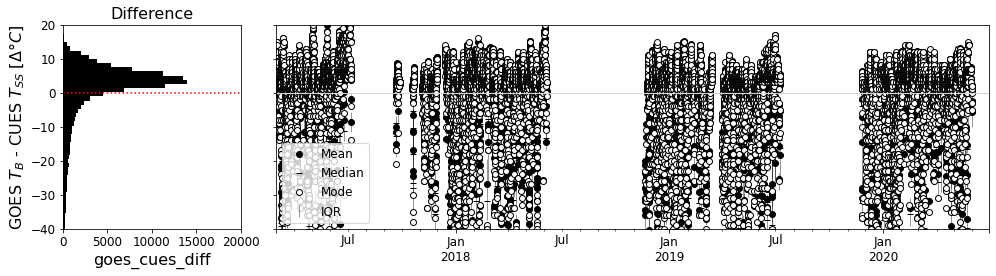

In [13]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='1H')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
resampled_plot(resampled_df, ymin=-20, ymax=20, xmin=0, xmax=1500, nbins=100)
# Plot the results2
resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)

### 6H resample

(<Figure size 1008x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9630aecd30>,
       dtype=object))

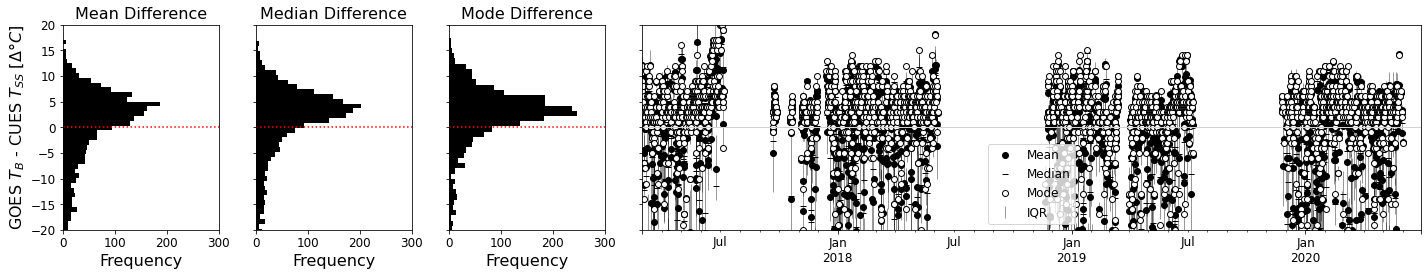

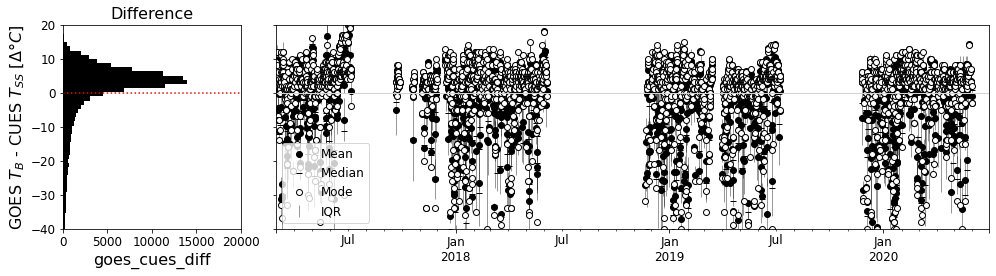

In [14]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='6H')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
resampled_plot(resampled_df, ymin=-20, ymax=20, xmin=0, xmax=300, nbins=100)
# Plot the results2
resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)

### 12H resample

(<Figure size 1008x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96397cb048>,
       dtype=object))

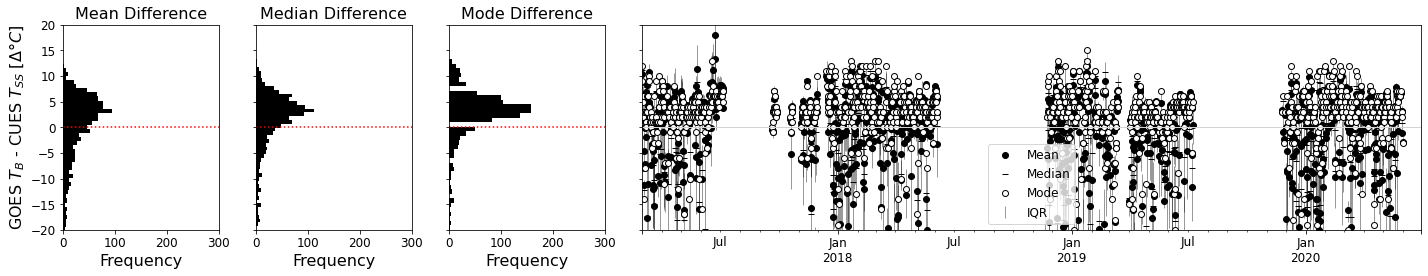

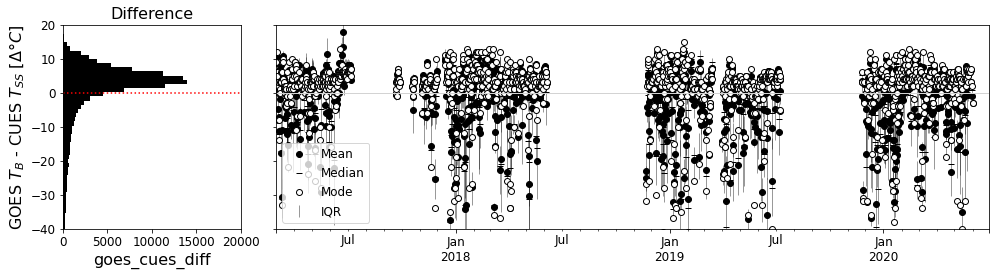

In [15]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='12H')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
resampled_plot(resampled_df, ymin=-20, ymax=20, xmin=0, xmax=300, nbins=80)
# Plot the results2
resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)

### 1D resample

(<Figure size 1008x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96204aafd0>,
       dtype=object))

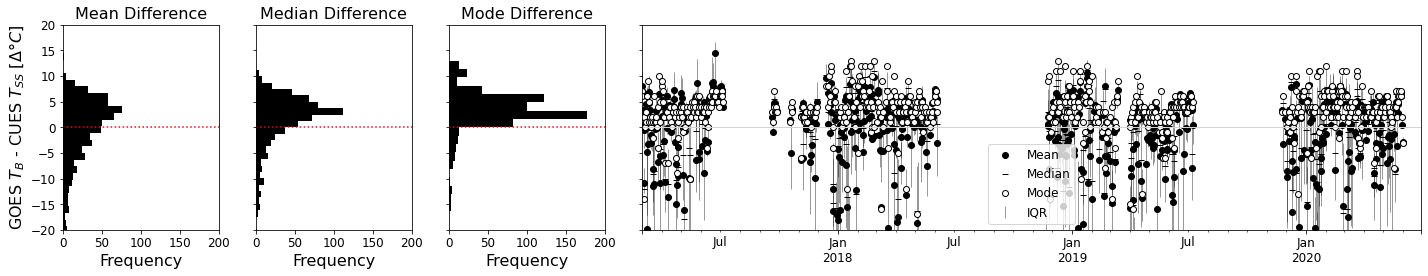

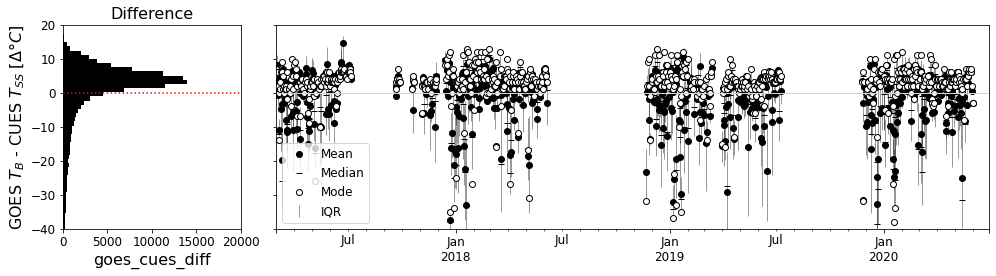

In [16]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='1D')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
resampled_plot(resampled_df, xmin=0, xmax=200, nbins=40)
# Plot the results2
resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)

### 1W resample

(<Figure size 1008x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9630813198>,
       dtype=object))

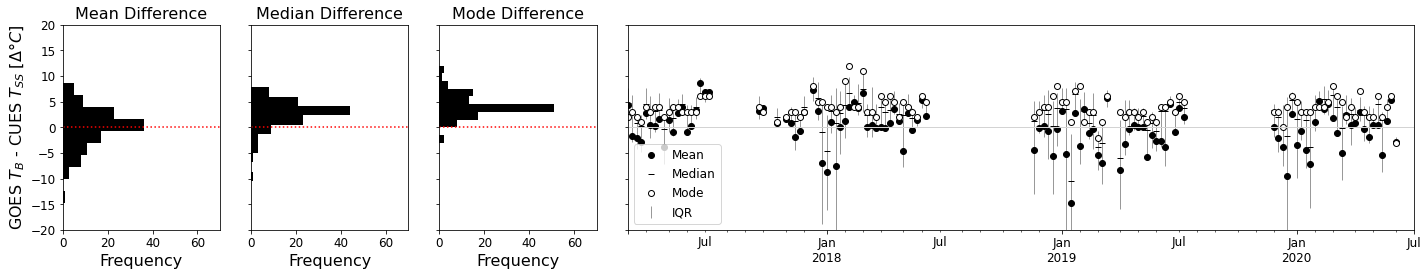

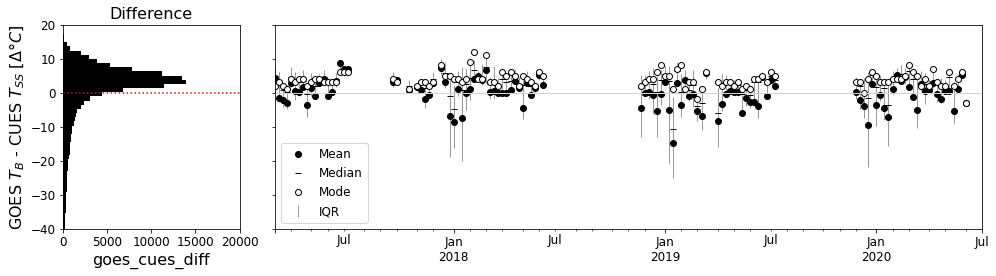

In [17]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='1W')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
resampled_plot(resampled_df, xmin=0, xmax=70, nbins=10)
# Plot the results2
resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)

### 1M resample

(<Figure size 1008x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96381aa278>,
       dtype=object))

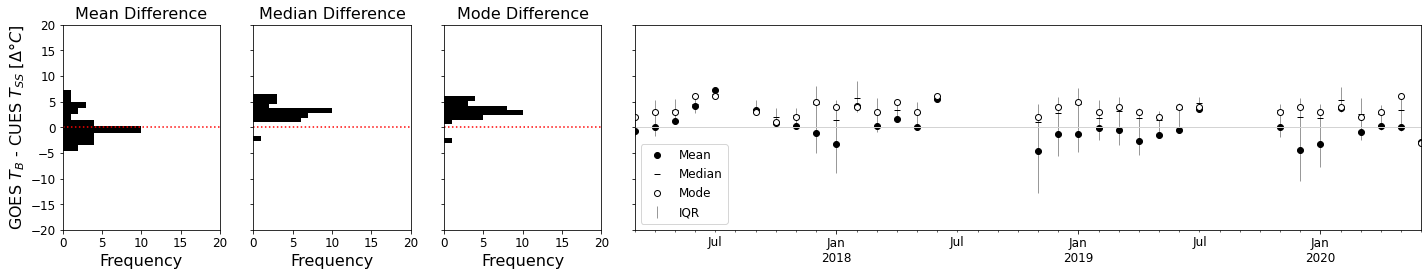

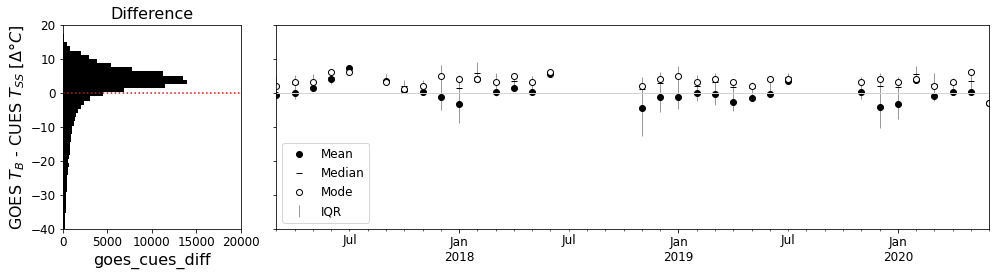

In [18]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.resample(datetime='1M')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
# Plot the results2
resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)

### Month of Year groupby

(0.0, 13.0)

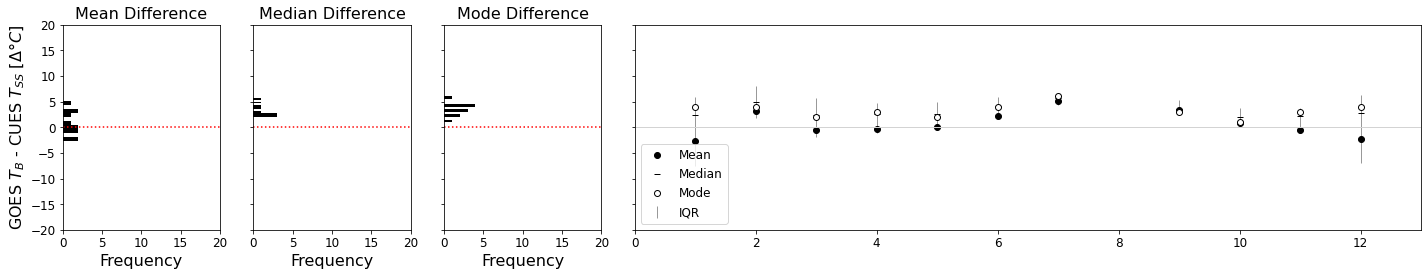

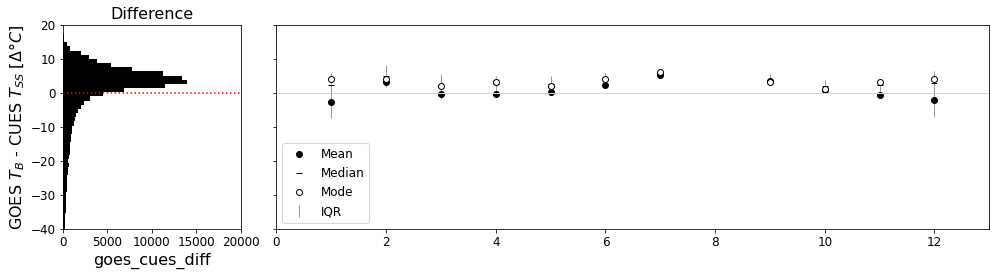

In [19]:
# Create DataArrayResample object
resampled_ds = cues_snow.goes_cues_diff.groupby('datetime.month')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)
# Plot the results
fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
ax[3].set_xlim((0,13)) # fix axis limits

# Plot the results2
fig, ax = resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)
ax[1].set_xlim((0,13)) # fix axis limits

### Hour of Day, by Month groupby

In [20]:
df = cues_snow.to_dataframe()

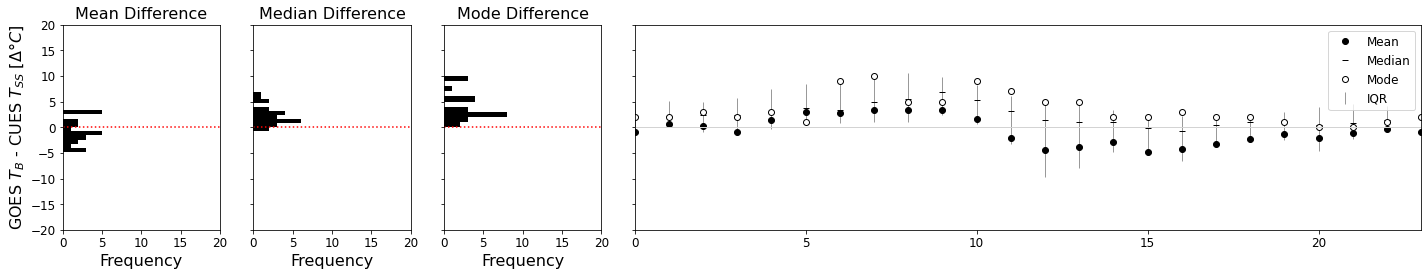

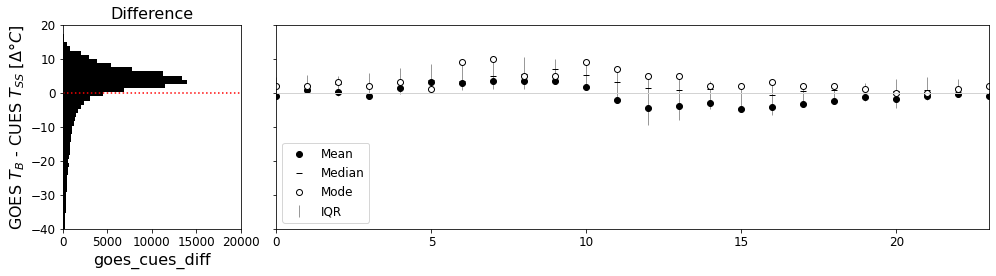

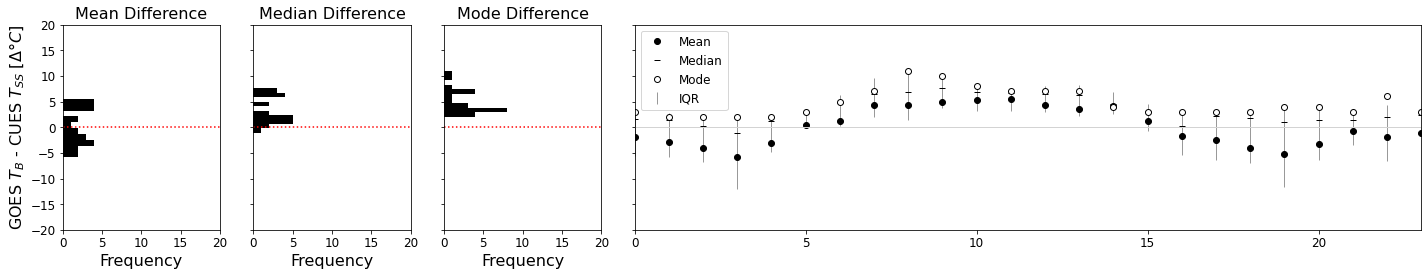

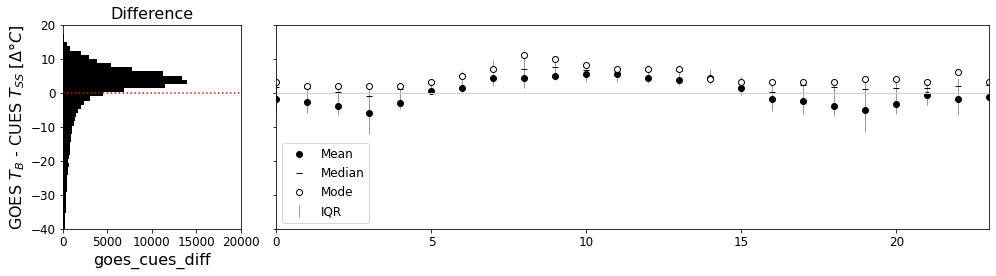

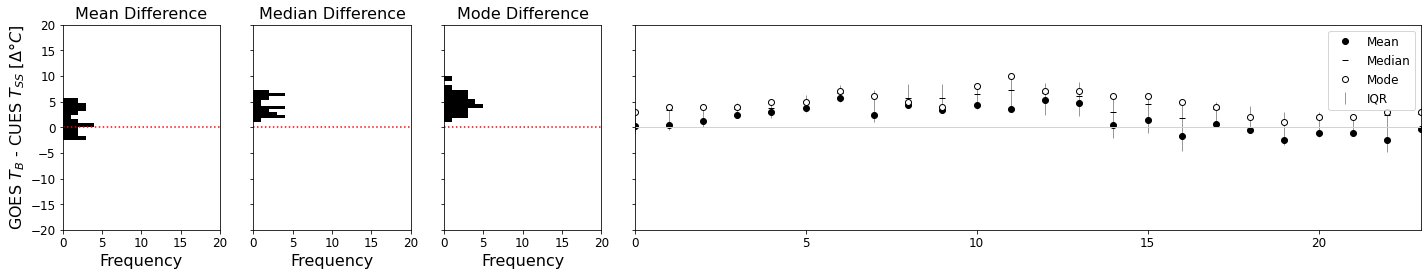

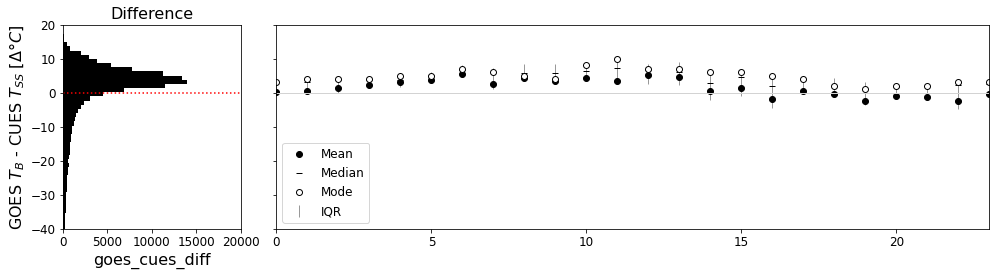

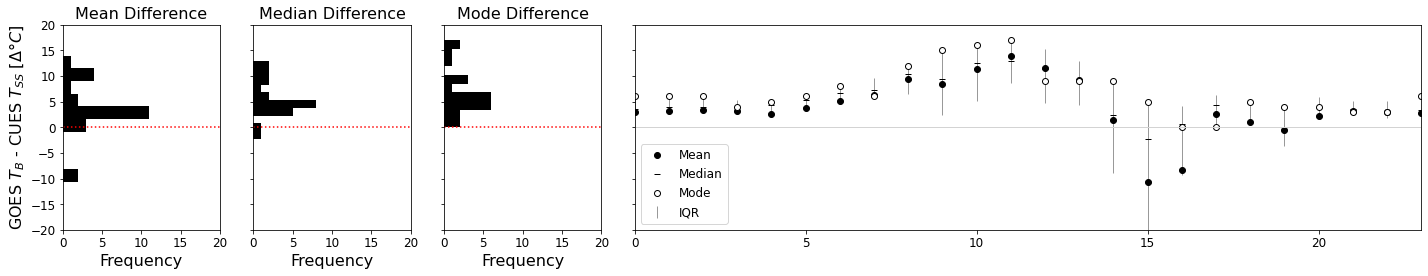

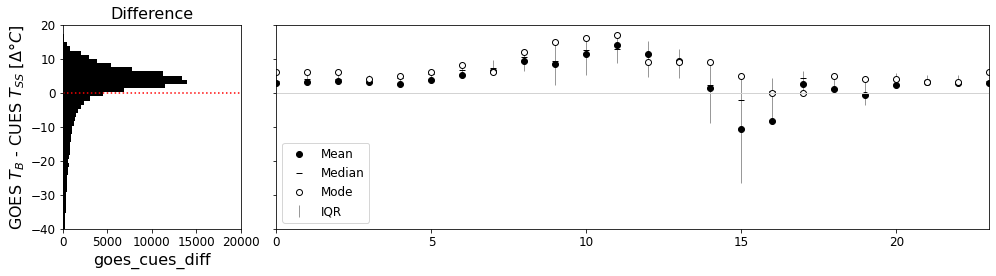

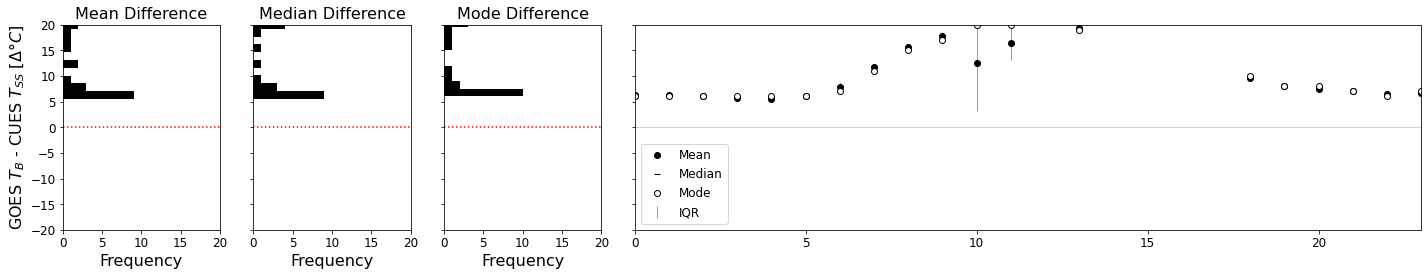

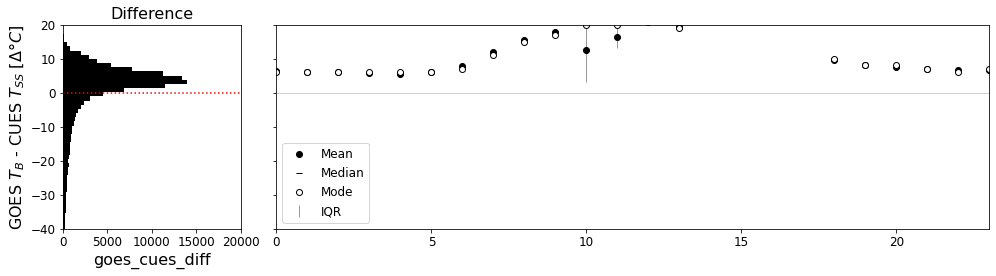

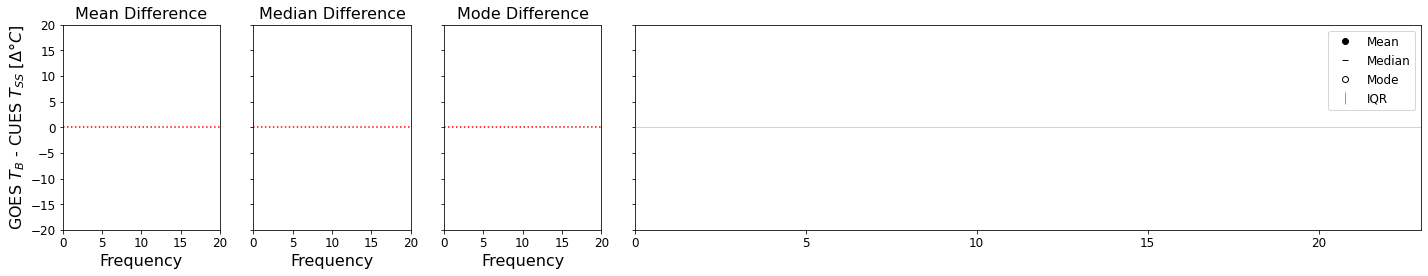

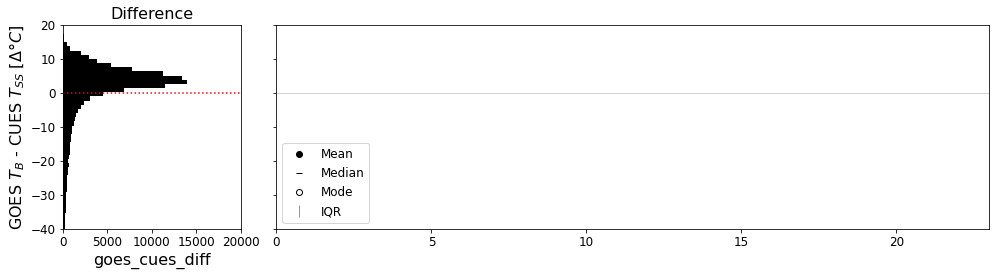

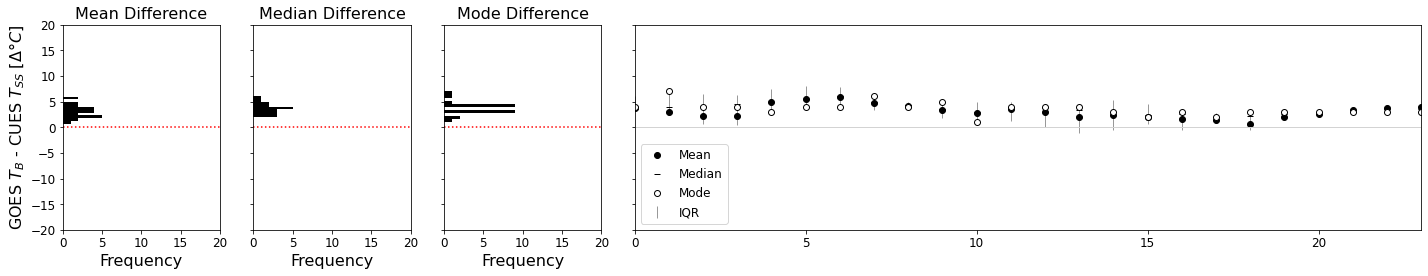

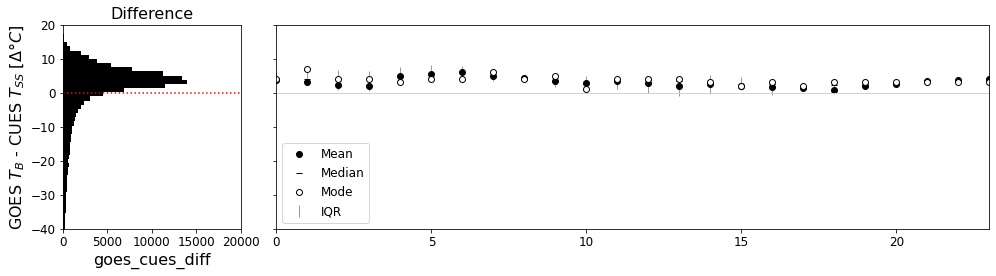

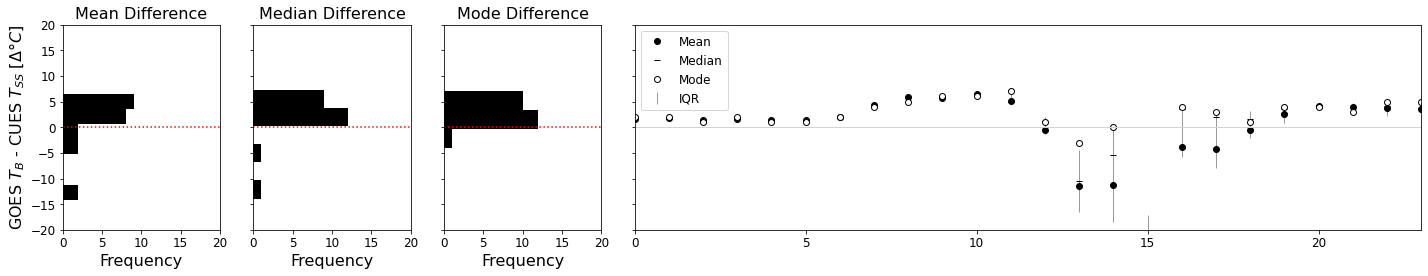

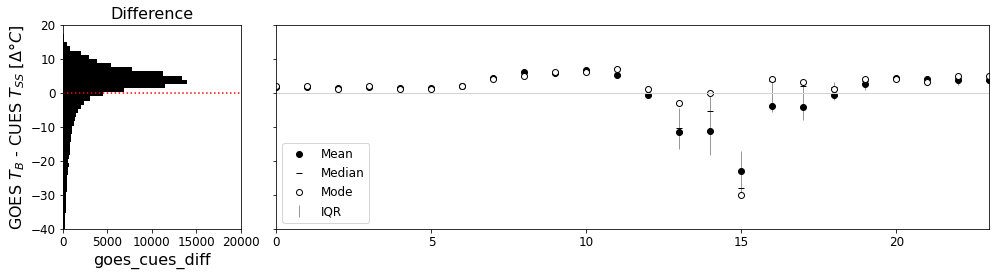

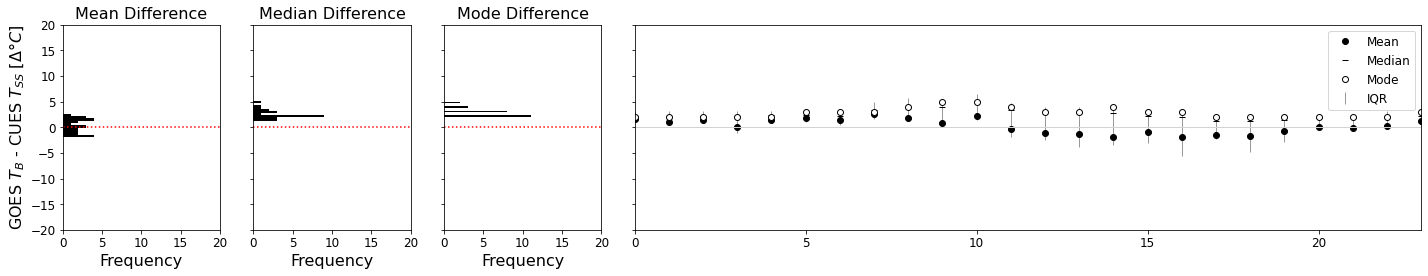

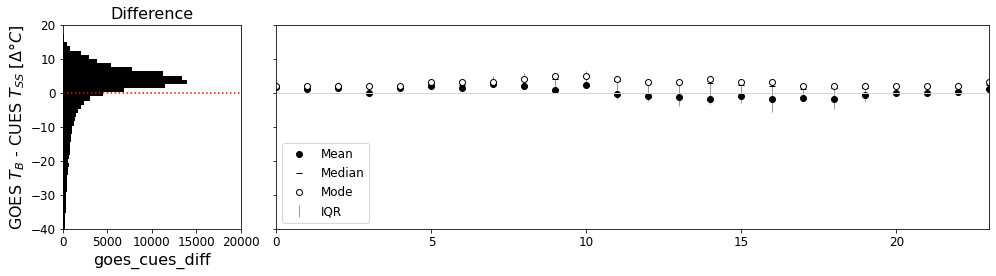

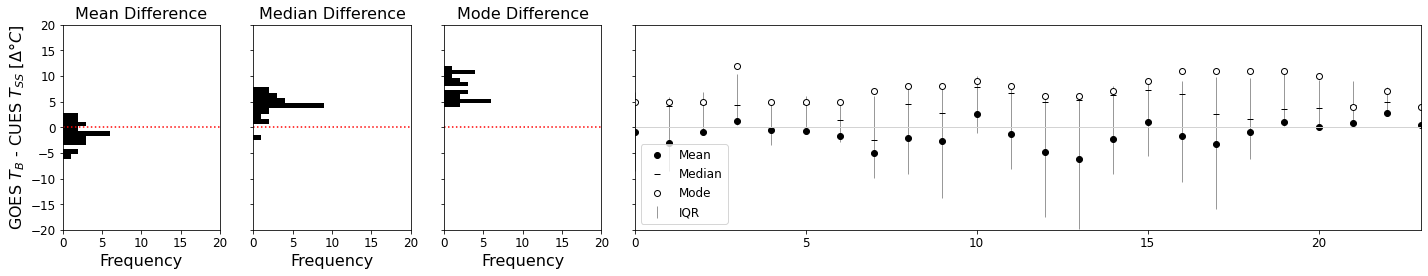

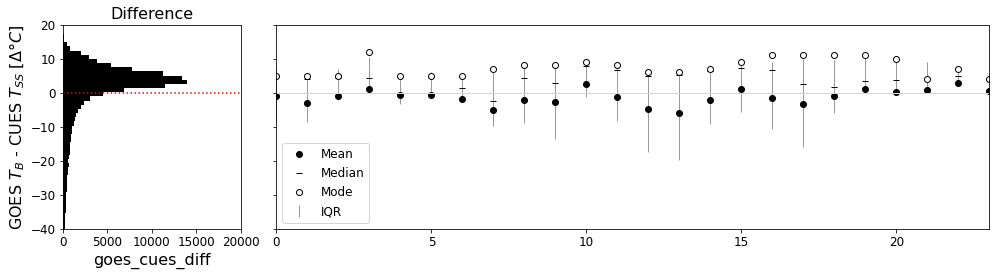

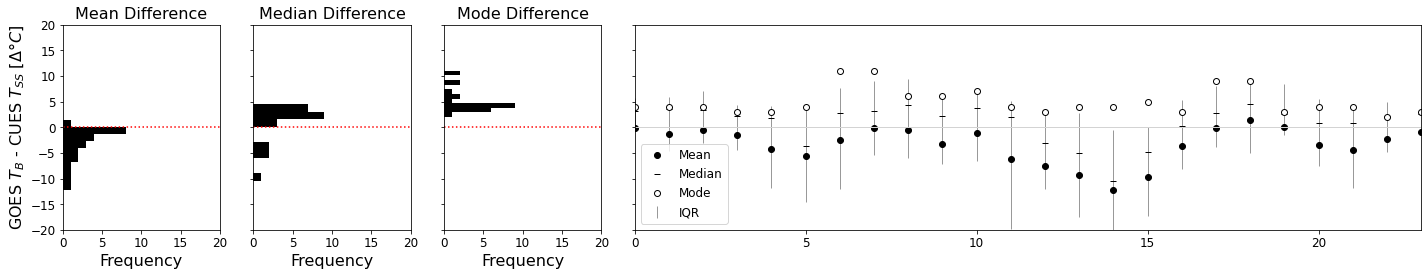

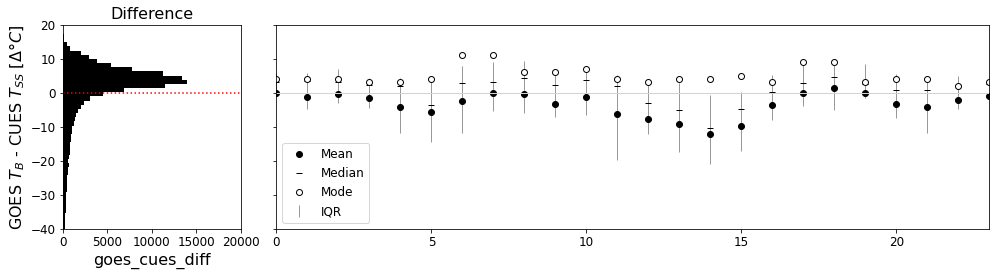

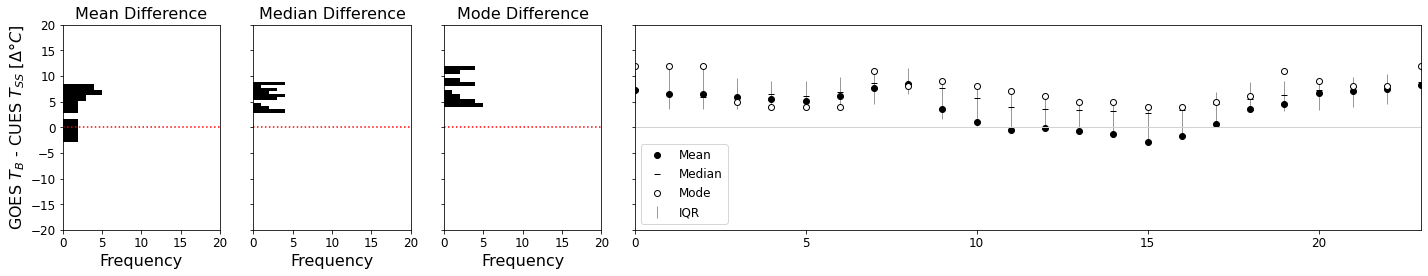

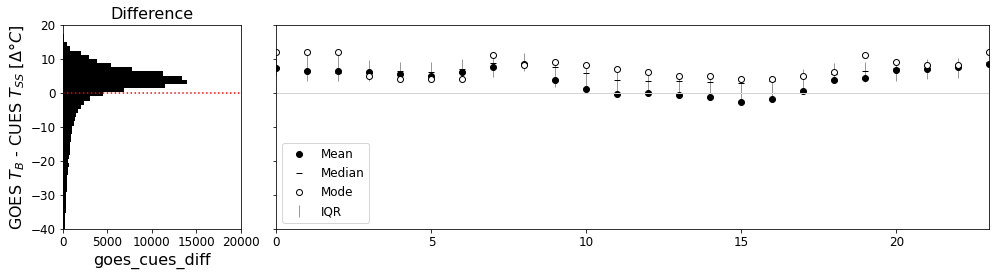

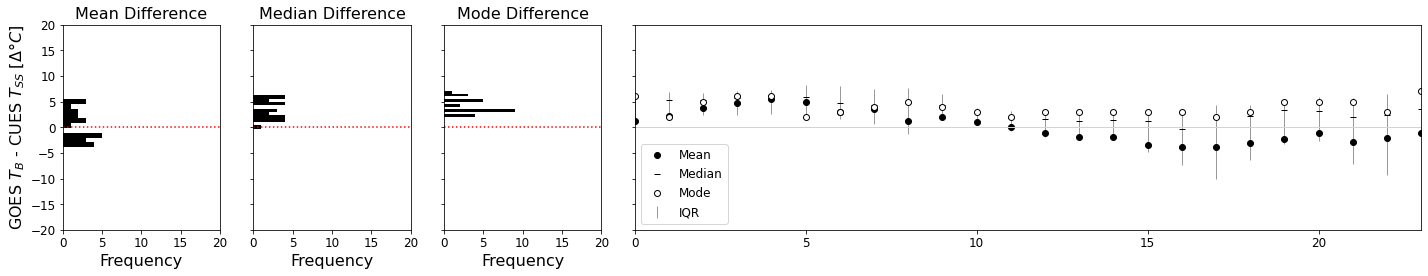

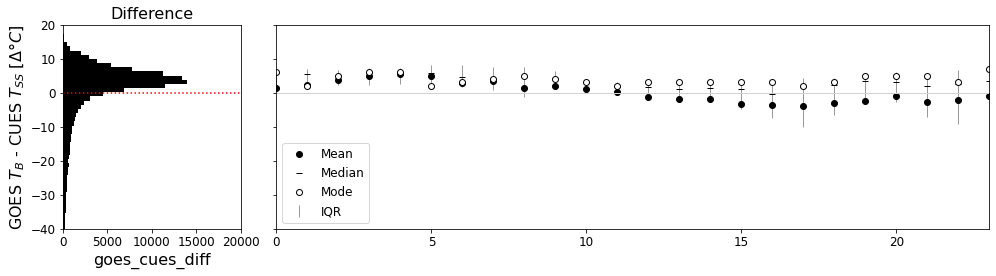

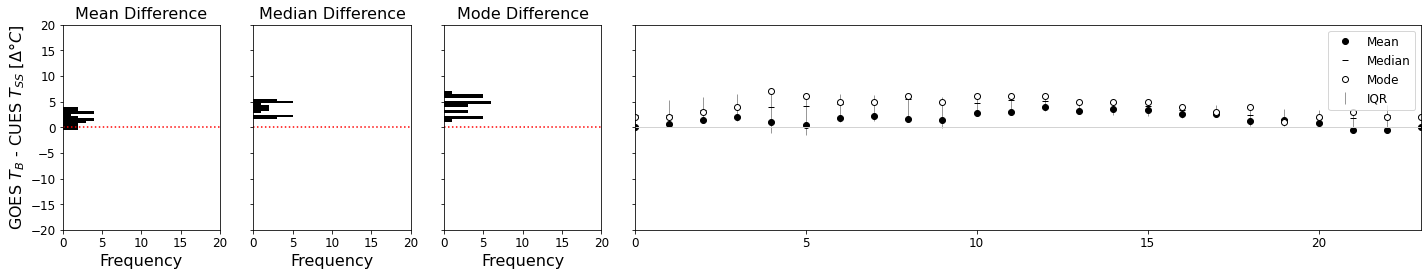

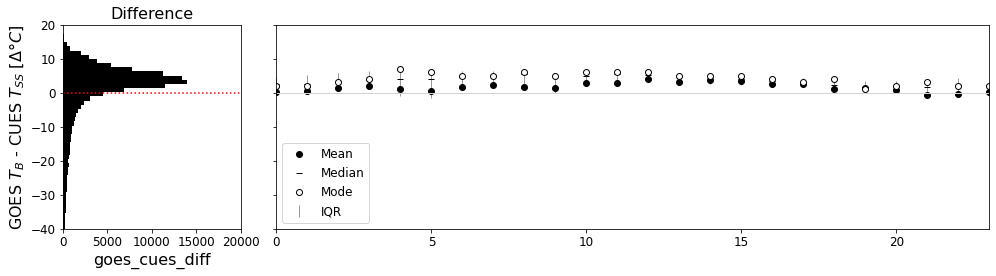

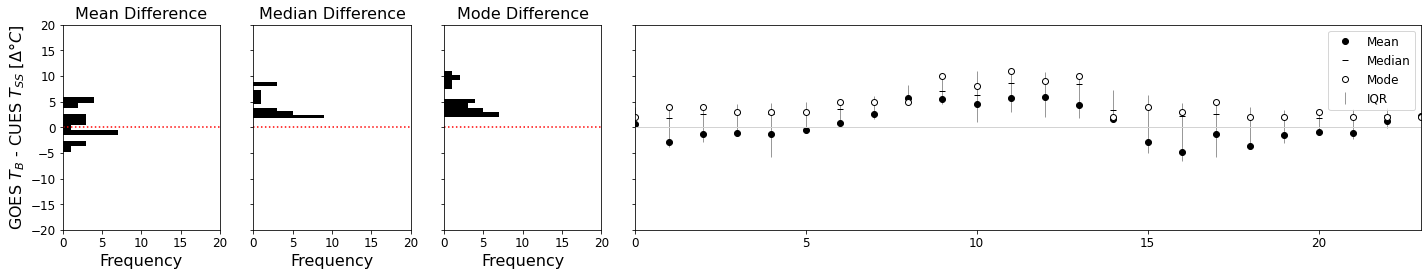

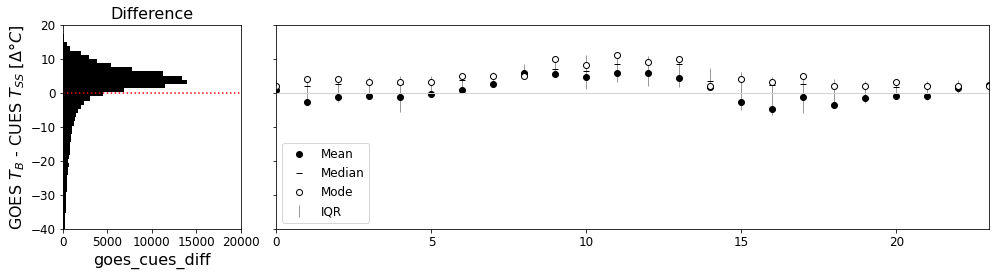

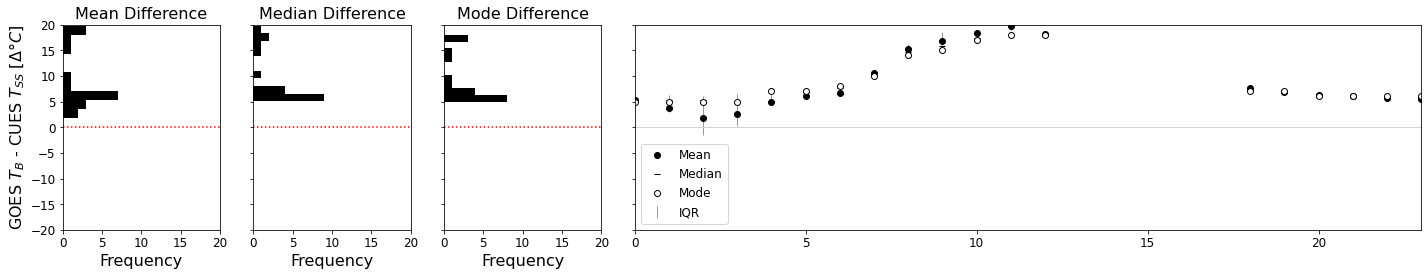

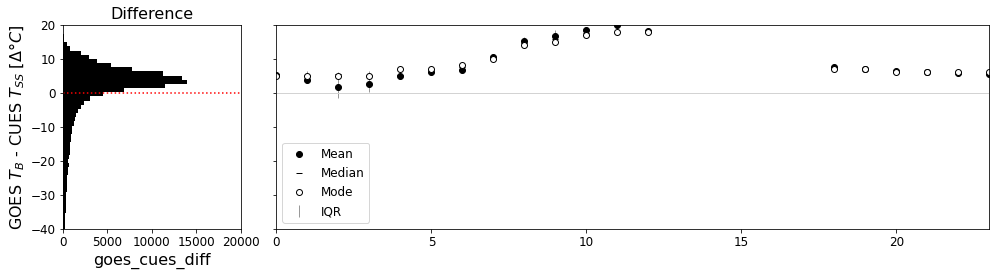

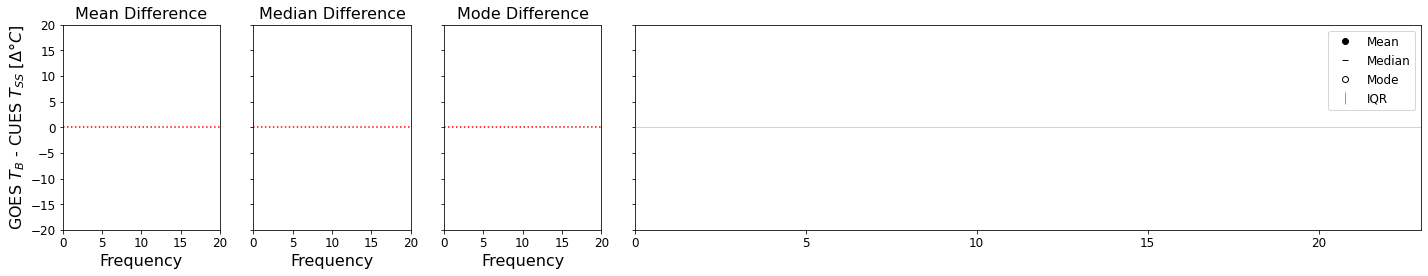

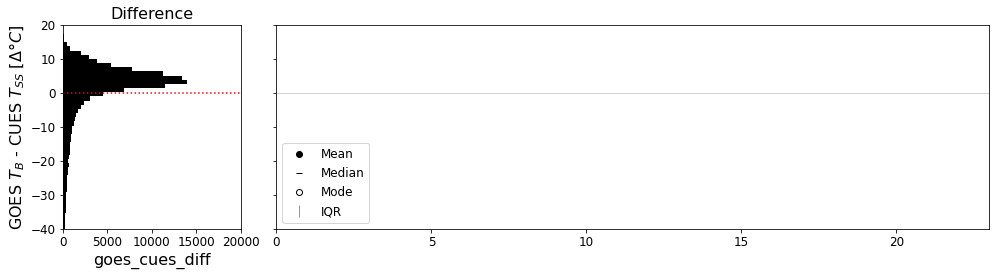

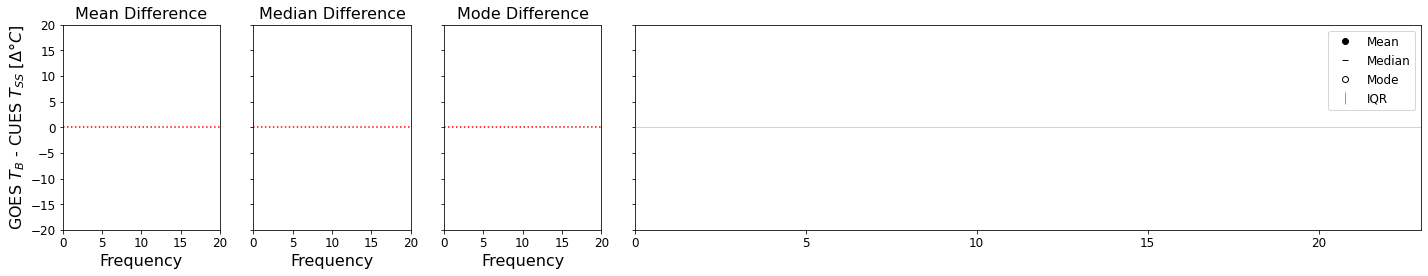

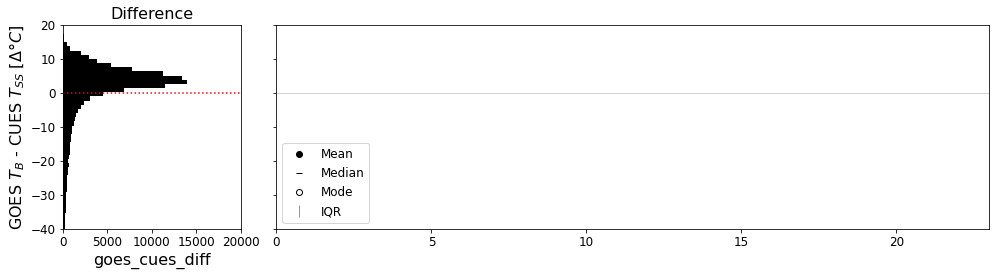

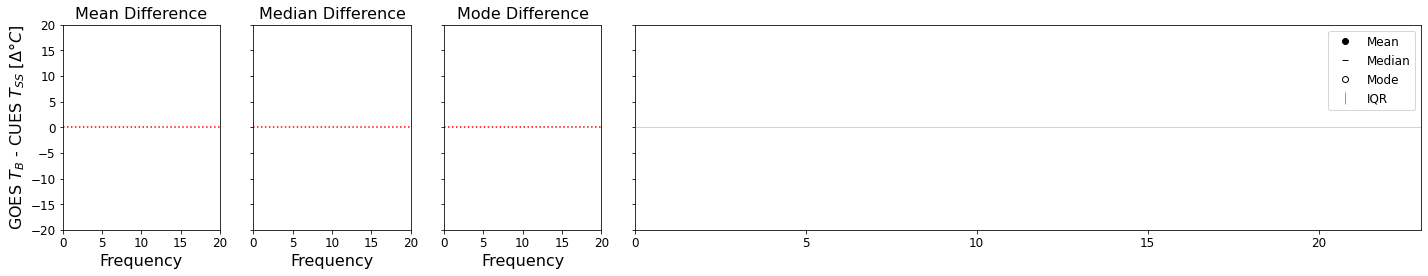

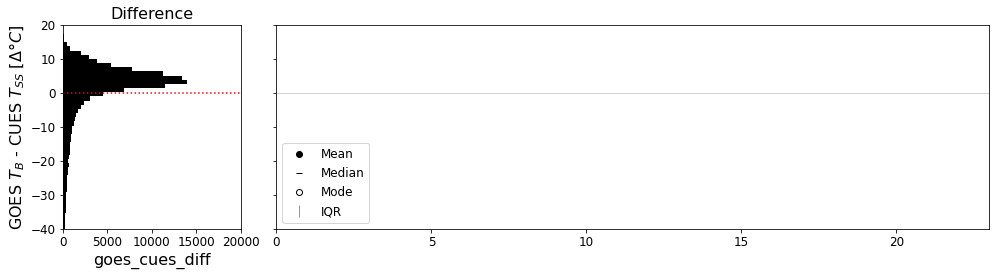

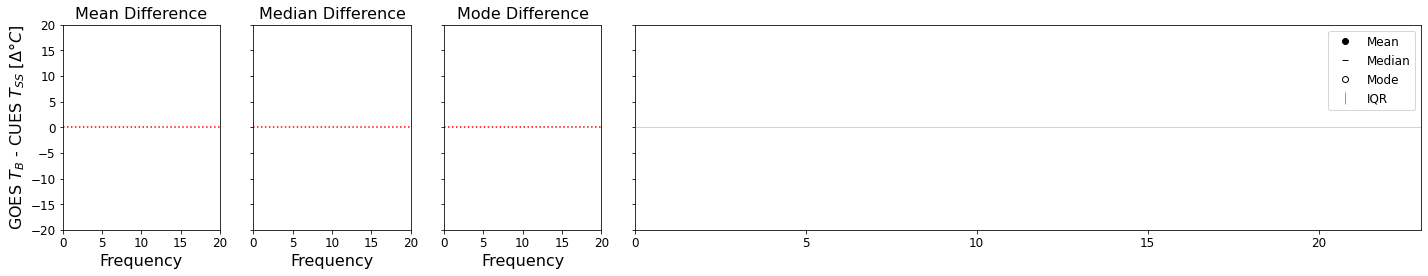

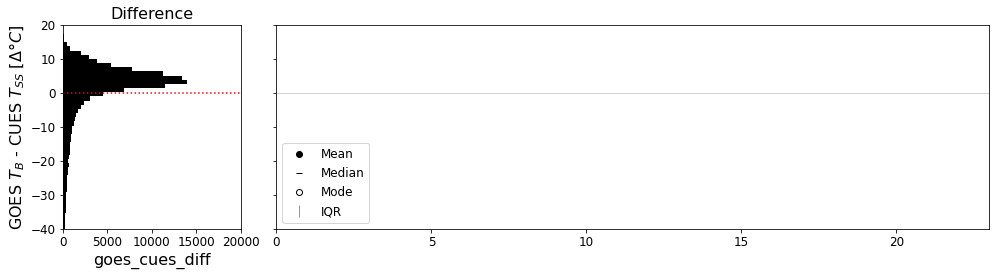

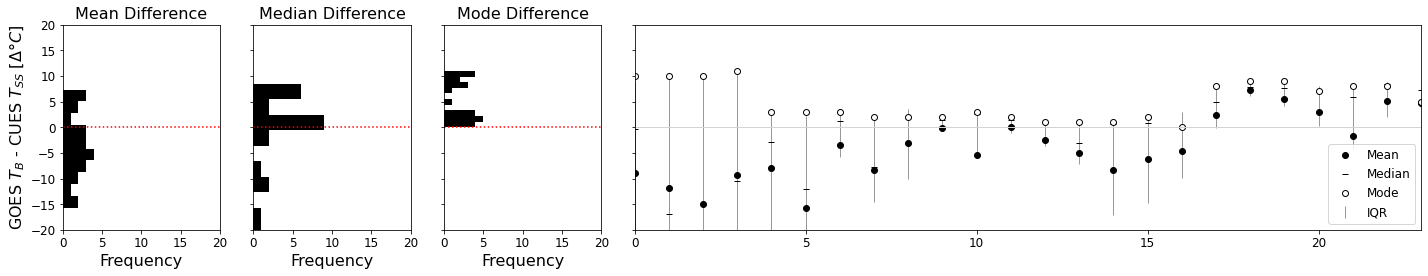

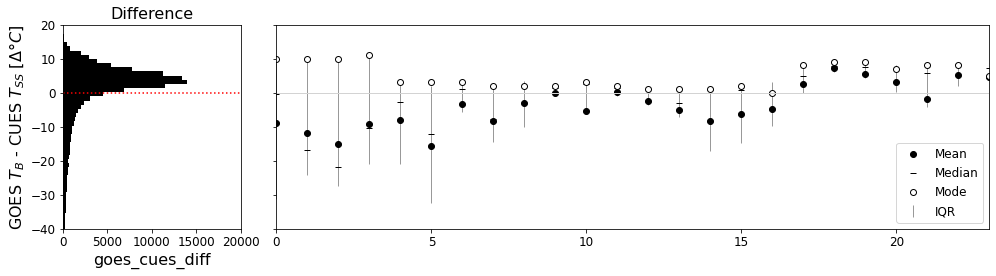

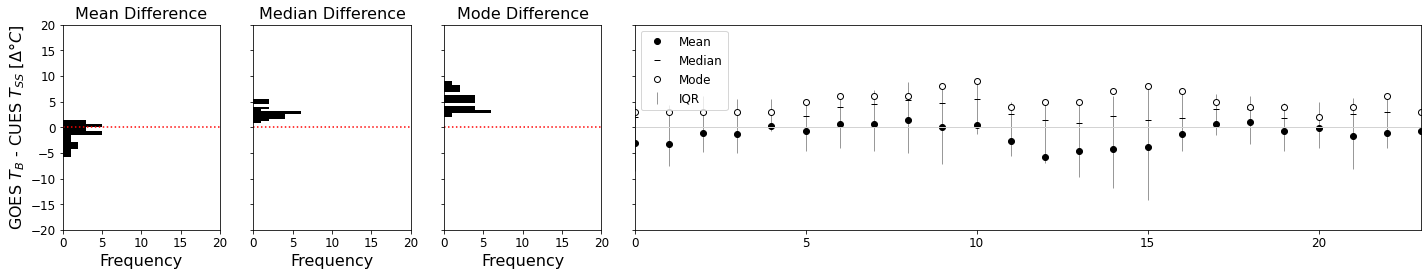

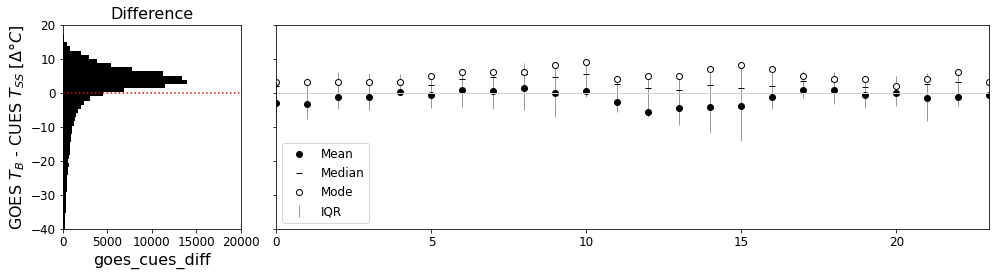

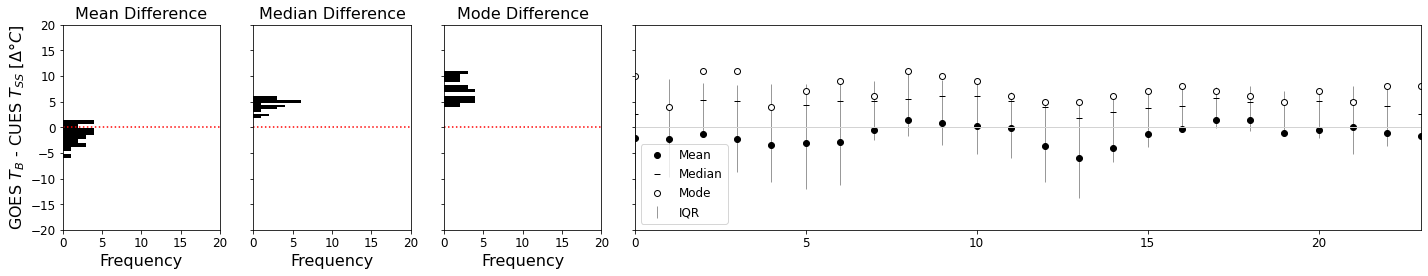

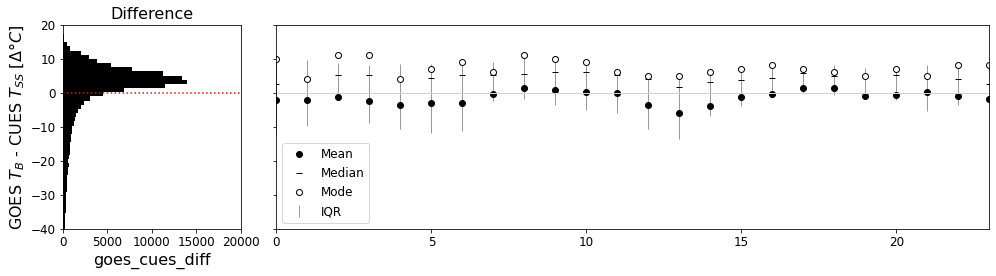

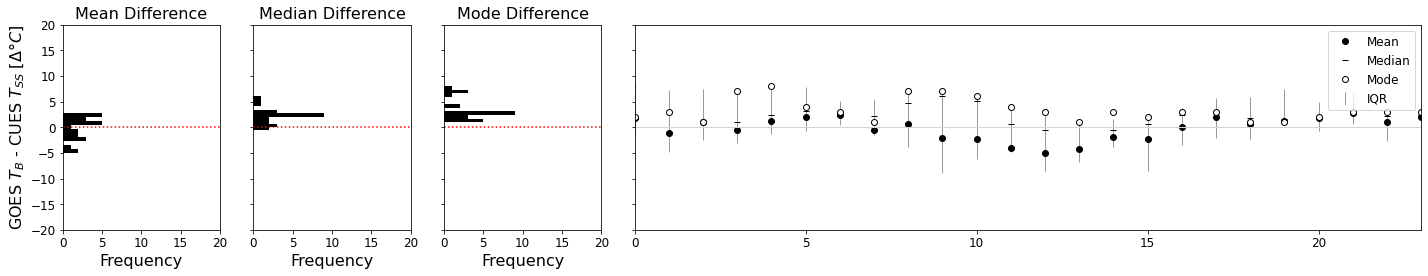

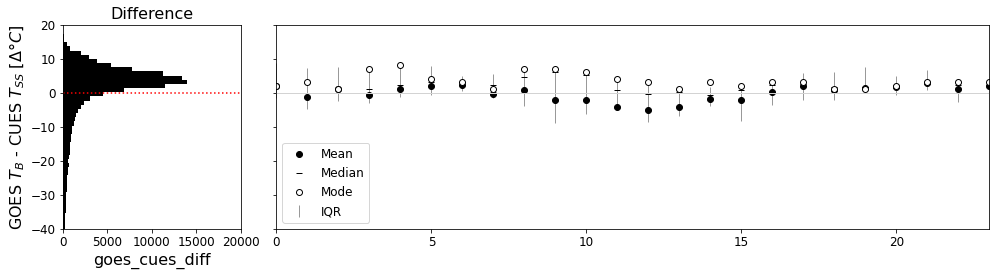

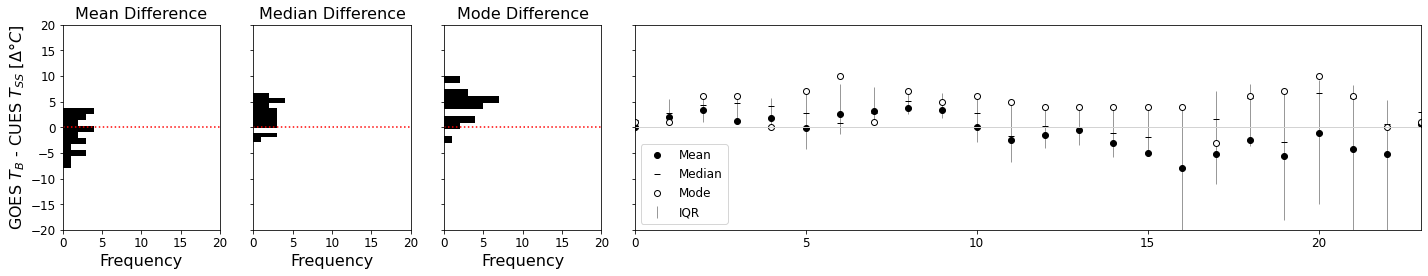

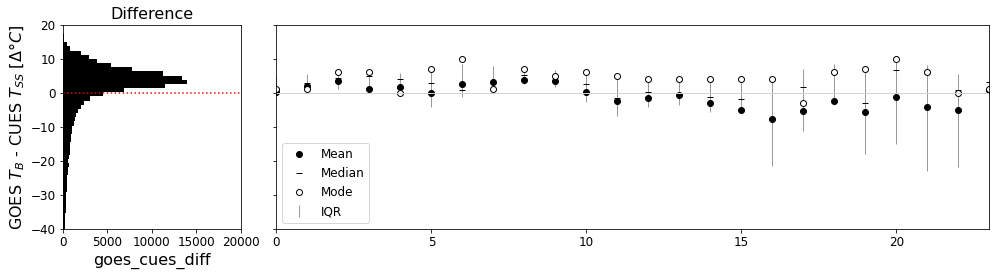

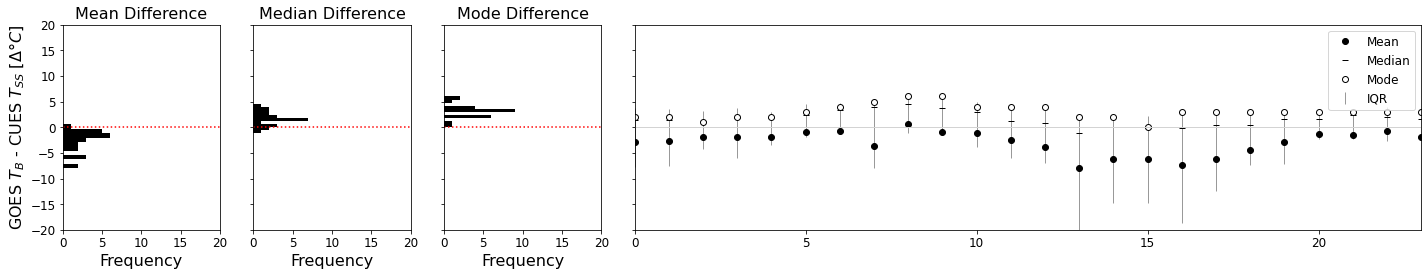

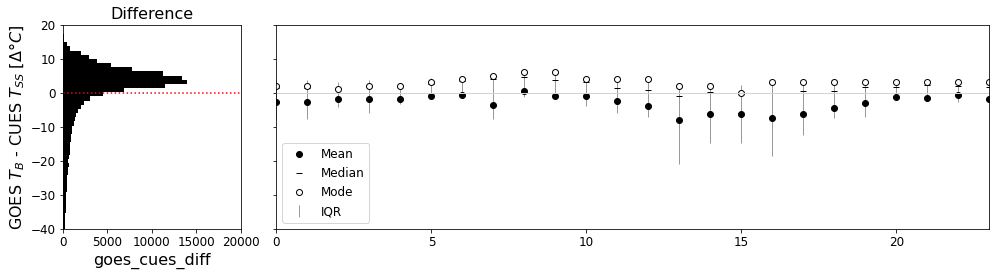

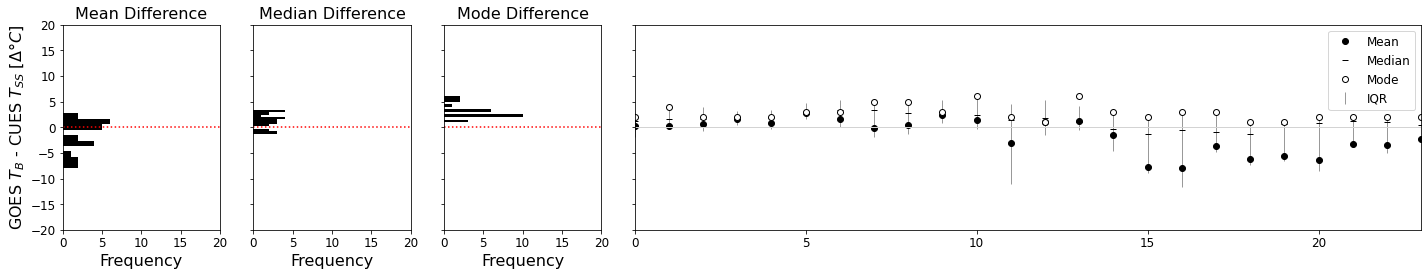

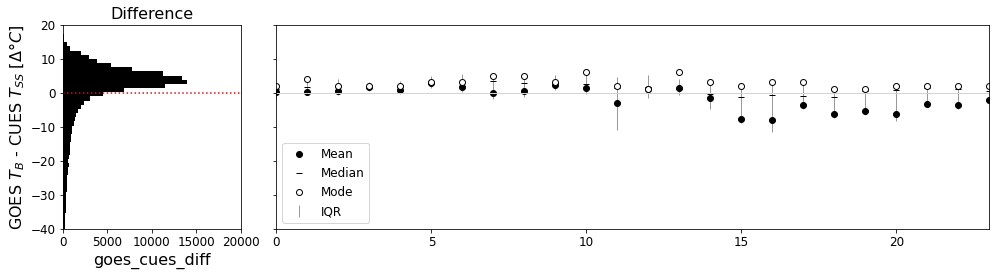

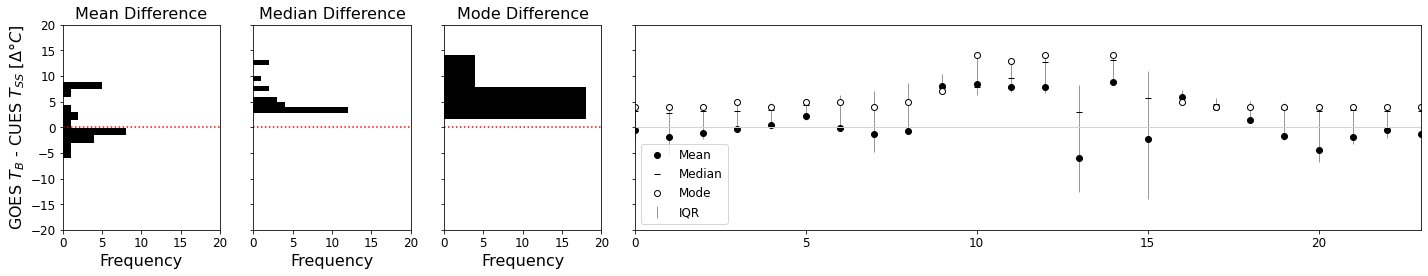

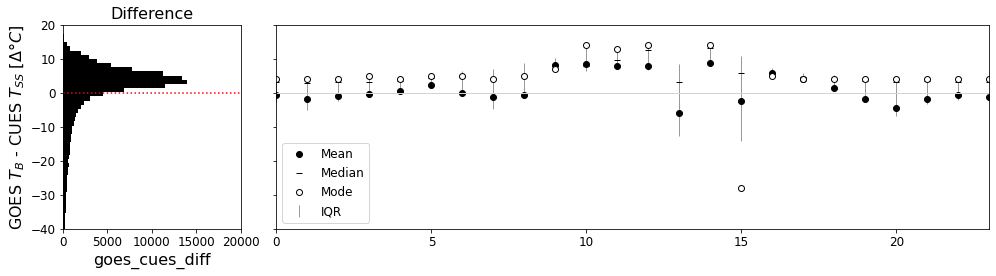

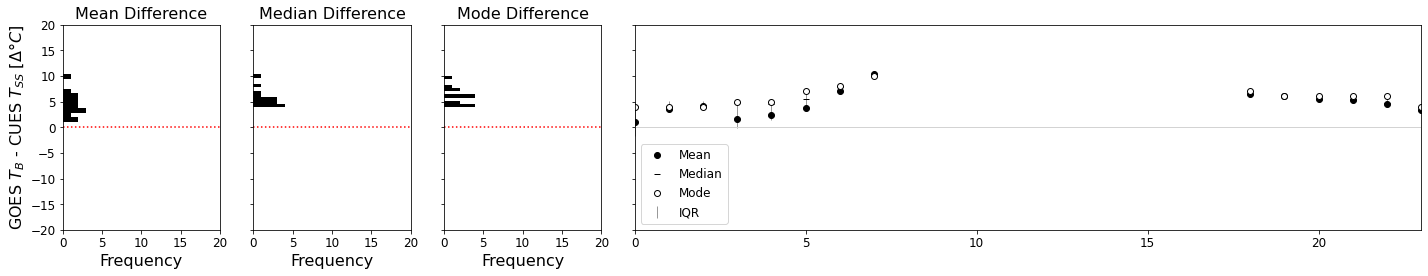

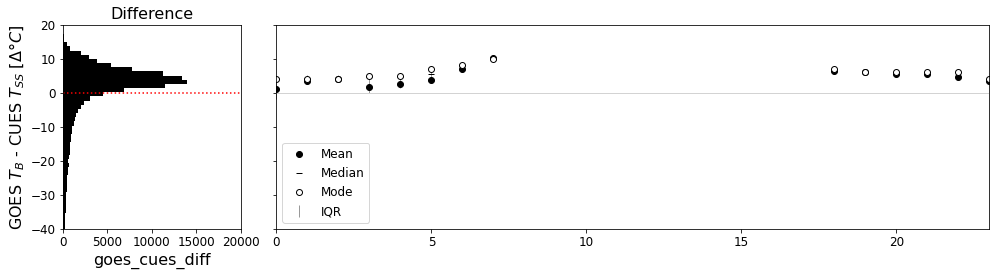

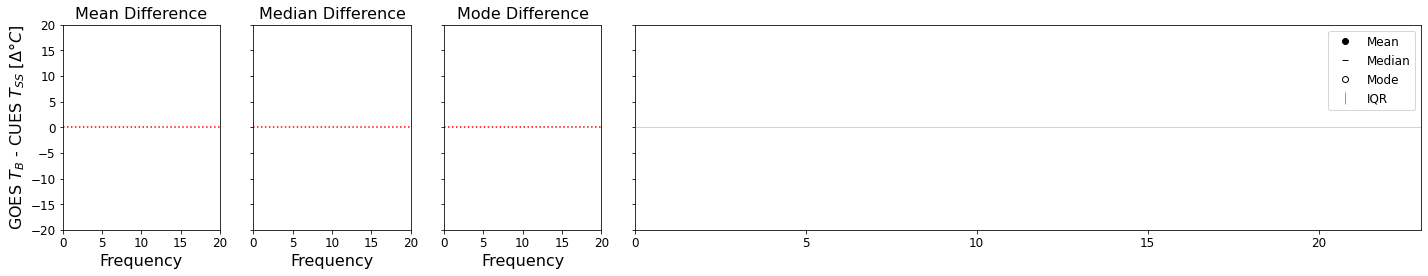

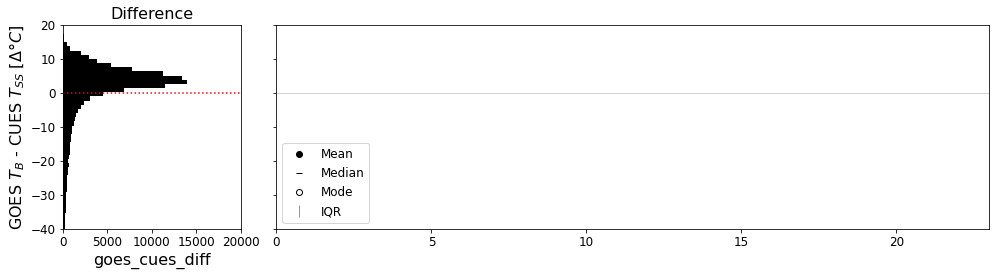

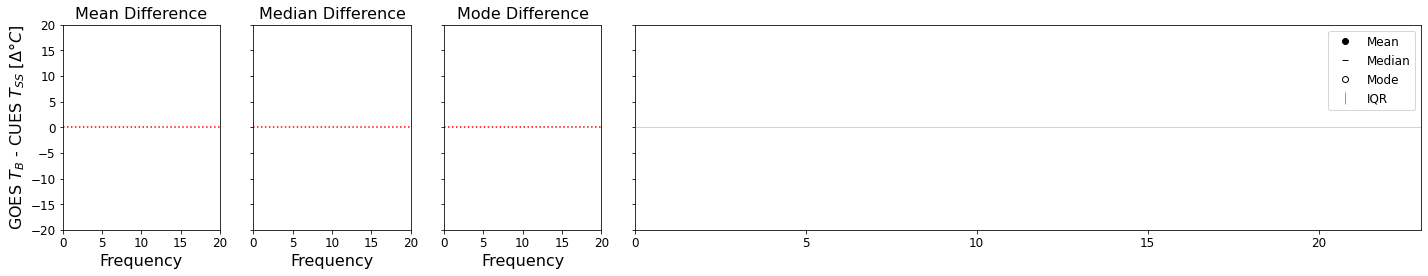

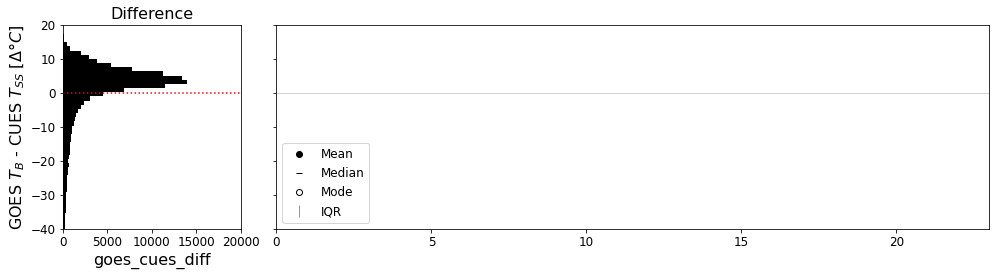

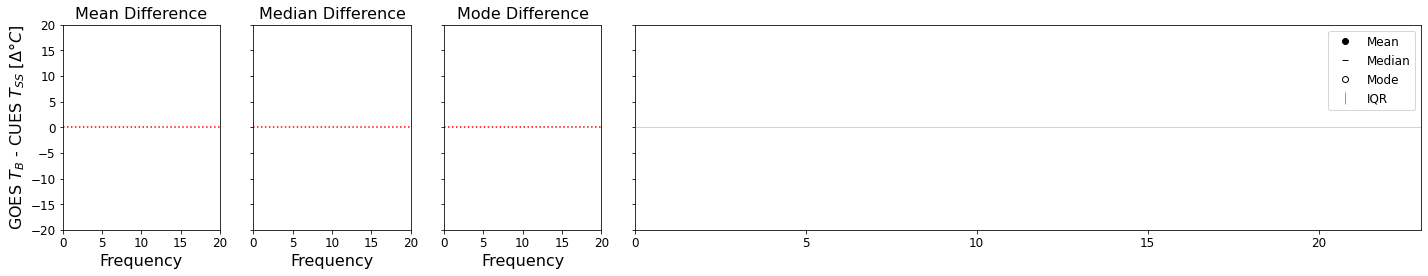

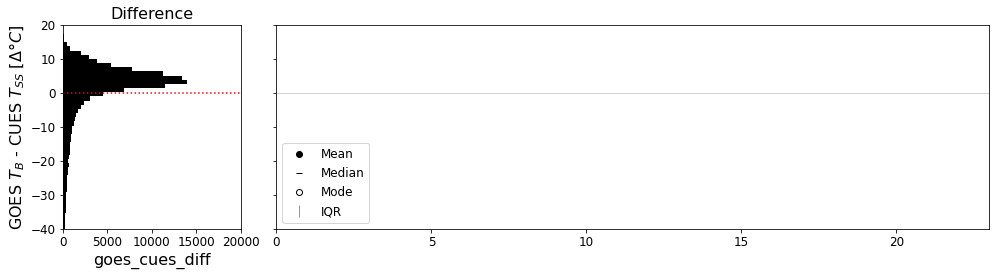

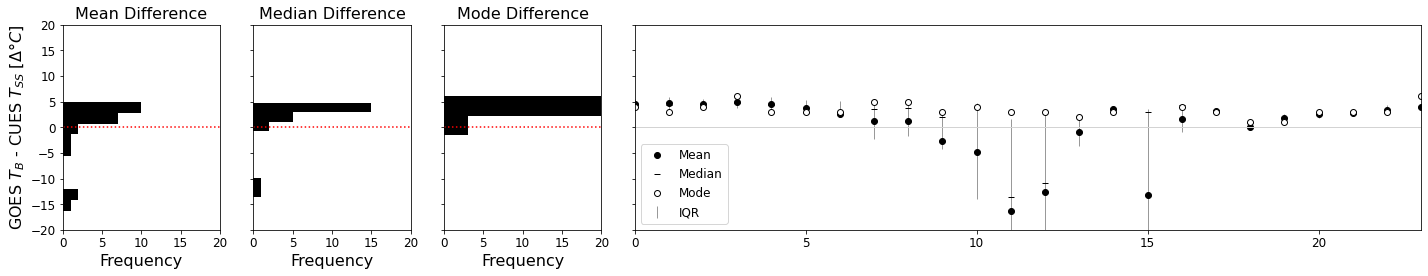

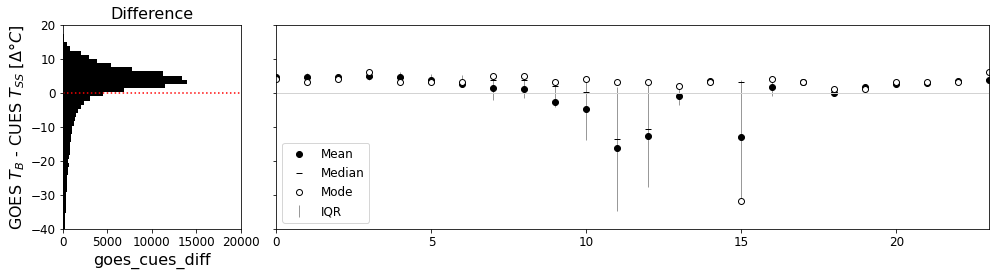

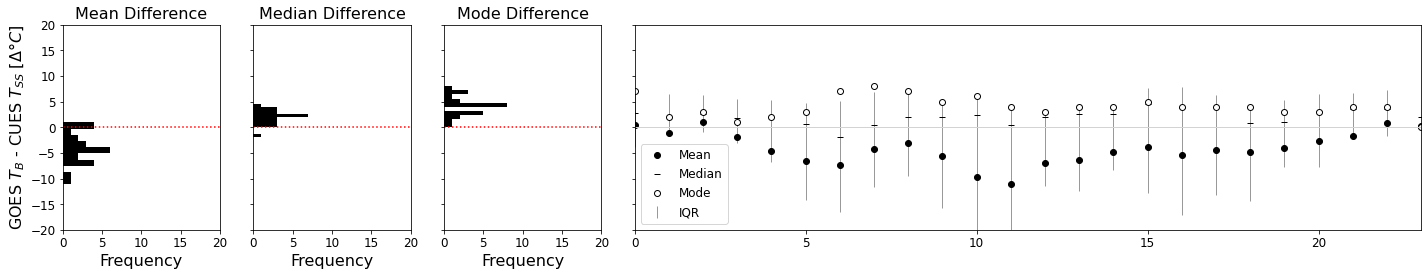

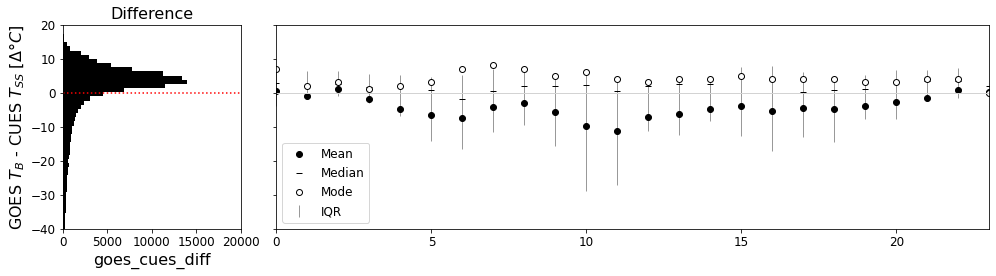

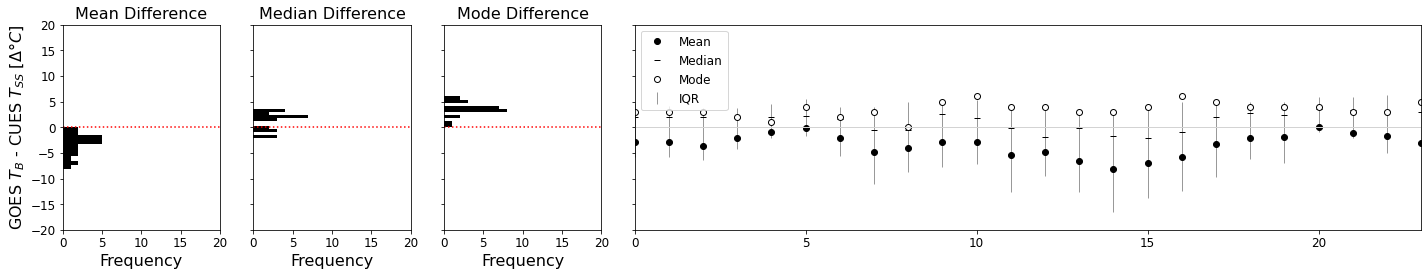

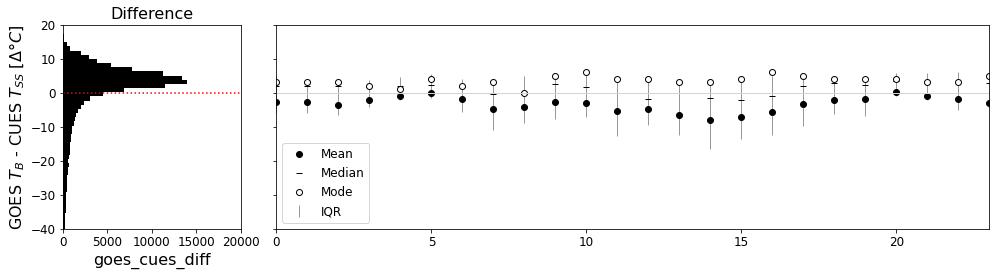

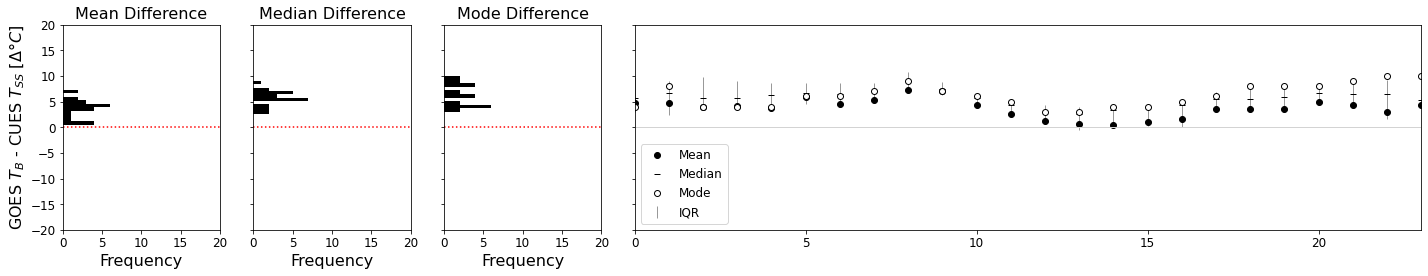

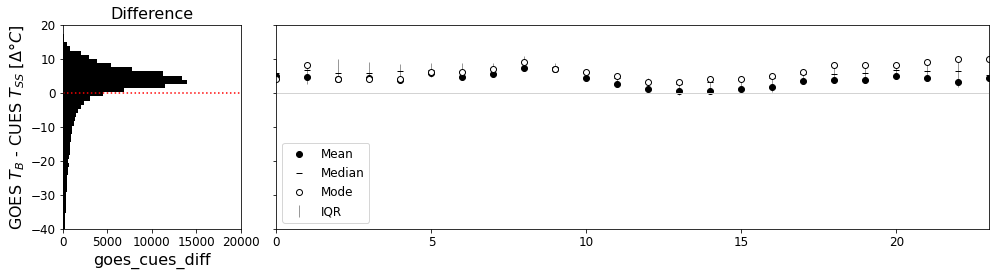

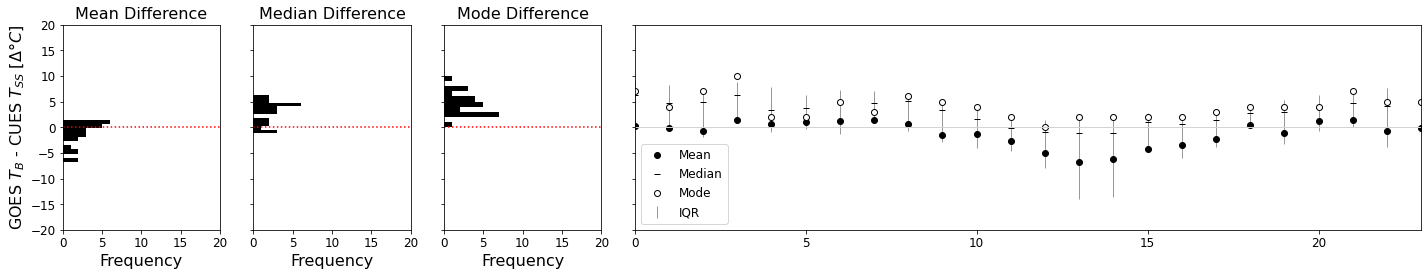

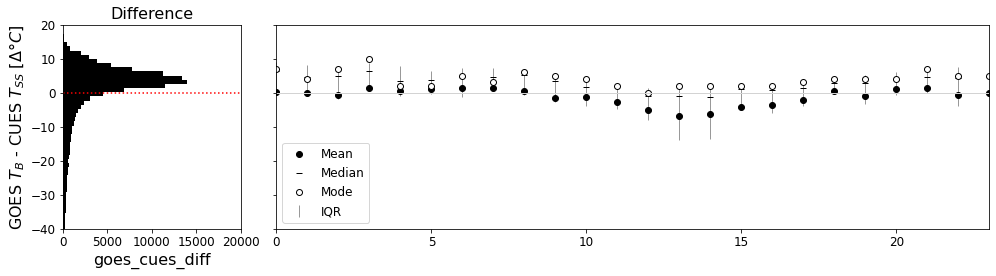

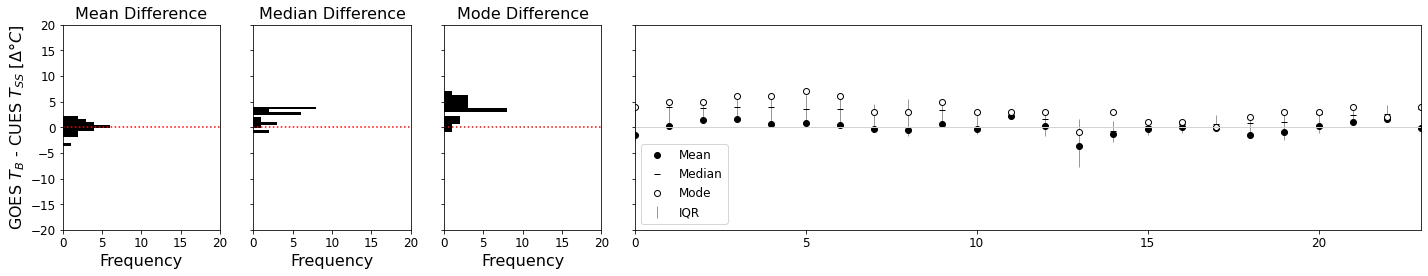

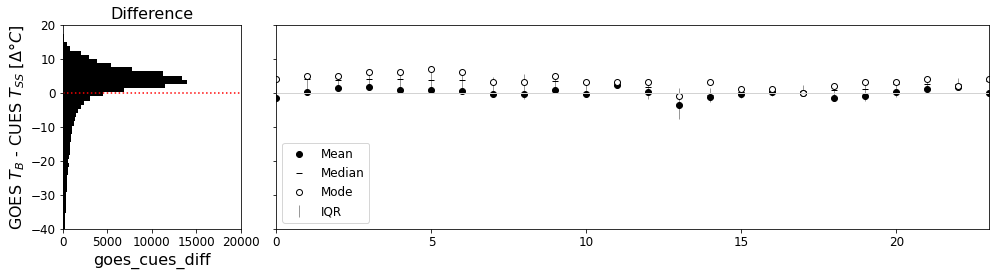

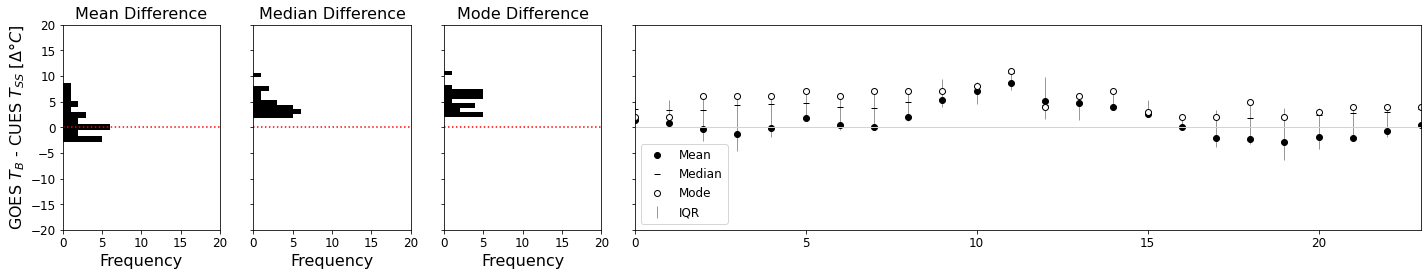

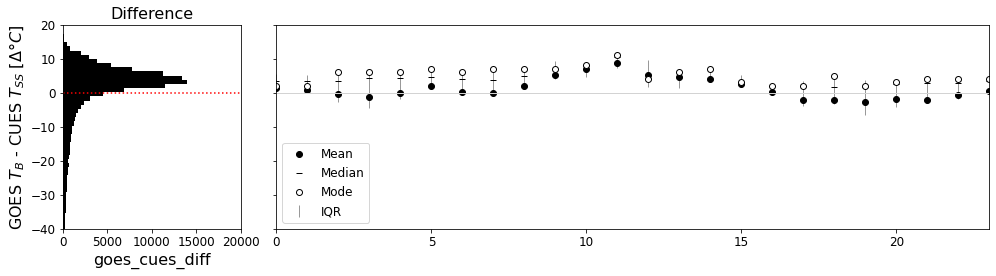

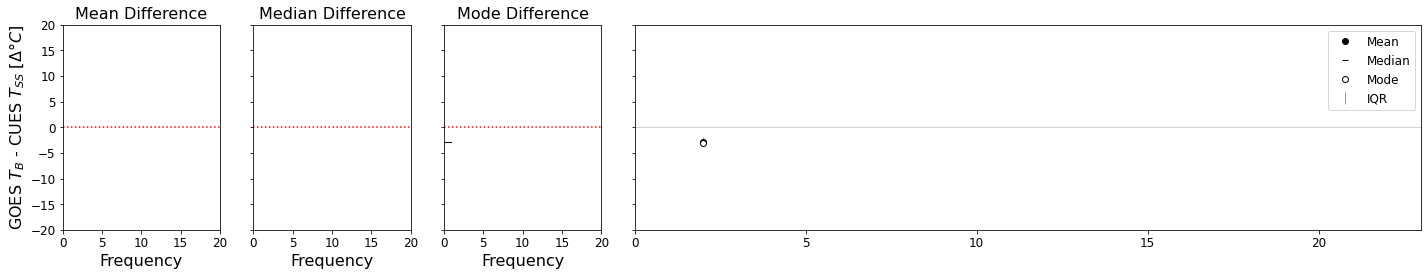

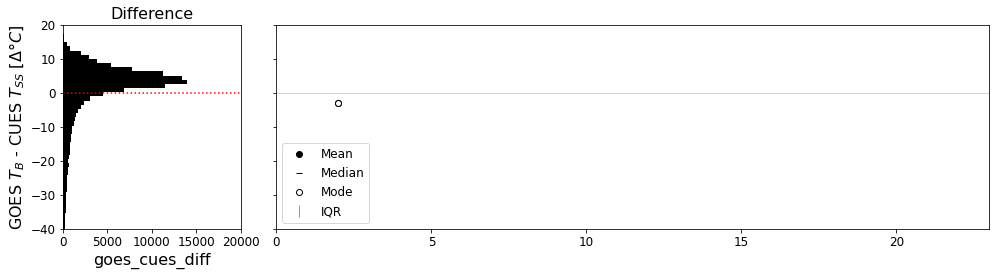

In [21]:
for year in df.index.year.unique():
    mask = df.index.year==year
    df_n = df.loc[mask]
    
    for month in df_n.index.month.unique():
        mask = df_n.index.month==month
        df_m = df_n.loc[mask]

        # Create DataArrayResample object
        resampled_ds = df_m.goes_cues_diff.groupby(df_m.index.hour)
        # Run the resampled_stats function
        resampled_df = rs.resampled_stats(resampled_ds, 0)
        # Plot the results
        fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
        # Plot the results2
        fig, ax = resampled_plot2(cues_snow.goes_cues_diff, resampled_df, ymin=-40, xmin=0, xmax=20000, nbins=100)